# A Structured Self-attentive Sentence Embedding

After the novelty of word embeddings to create new numerical representations of words, natural language processing (NLP) has still been effectively improved in many ways. Along with the widespread use of embedding techniques, many other methods have been developed to further express the semantics and meanings of sentences with words:

1. A vector representation of multiple words in a sentence can be concatenated or weighted to obtain a vector to represent the entirety of a sentence.

2. Convolution (CNN) and maximum pooling (MaxPooling) on the matrix of all the word vectors of the sentence, using the final result of these techniques to represent the sentence as a whole.

3. Unrolling the sentence according to the time step of the word, inputting the vector representation of each word into a recurrent neural network (RNN), and using the output of the last time step of the RNN as the representation of the sentence.

The above methods solve the problem of sentence meaning, but only to a certain extent. When concatenating is used in method one, if the word of the sentence is too long and the vector dimension of the word is slightly larger, then the vector dimension of the sentence will be particularly large, and the internal interaction between the words of the sentence can not be taken into account. The use of weighted averaging is not accurate and does not adequately express the impact of each word on sentence semantics.

In the second method, many useful word meanings may be lost using CNNs and MaxPooling.

In the third method, the representation selected is only the output of the last step. If a sentence is too long, the output of the last step does not accurately express the entirety of the sentence's semantics.

Based on the aforementioned method, Zhouhan Lin, Minwei Feng et al. published a paper [A Structured Self-attentive Sentence Embedding](https://arxiv.org/pdf/1703.03130.pdf)[1] in 2017, proposing a novel method based on self-attention structures for sentence embedding and application to users' review classification, textual entailment and other NLP tasks. In the end, better results were obtained than the previous methods.

In this tutorial, we will use [GluonNLP](https://gluon-nlp.mxnet.io/index.html) to reproduce the model structure in "A Structured Self-attentive Sentence Embedding" and apply it to [Yelp Data's review star rating data set](https://www.yelp.com/dataset/challenge) for classification.

## Importing necessary packages

The first step, as in every one of these tutorials, is to import the necessary packages.

In [1]:
import os
import json
import zipfile
import time
import itertools

import numpy as np
import mxnet as mx
import multiprocessing as mp
import gluonnlp as nlp

from mxnet import gluon, nd, init
from mxnet.gluon import nn, rnn
from mxnet import autograd, gluon, nd

# iUse sklearn's metric function to evaluate the results of the experiment
from sklearn.metrics import accuracy_score, f1_score

# fixed random number seed
np.random.seed(2018)
mx.random.seed(2018)

def try_gpu():
    """If GPU is available, return mx.gpu(0); else return mx.cpu()."""
    try:
        ctx = mx.gpu()
        _ = nd.array([0], ctx=ctx)
    except:
        ctx = mx.cpu()
    return ctx

## Data pipeline

The next step is to load and format the data according to the requirements of our model. The dataset used in this tutorial is the Yelp users' review dataset.

### Loading the dataset

The [Yelp users' review dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset) is formatted as a JSON. The original paper selected 500,000 documents as the training set, 2,000 as the validation set, and 2,000 as the test set. For easier reproducibility of the experiment, we subsampled 198,000 documents from this dataset as the training set and 2,000 documents as validation set.

Each sample in the data consists of a user's comment, in English, with each comment marked one through five, each number representing one of five different emotions the user expressed. Here we download, unzip, and reformat the dataset for ease of use further on.

In [2]:
# Download the data from the server
data_url = 'http://apache-mxnet.s3-accelerate.dualstack.amazonaws.com/gluon/dataset/yelp_review_subset-167bb781.zip'
zip_path = mx.gluon.utils.download(data_url)

# Unzip the zip file
zip_file = zipfile.ZipFile(zip_path)
json_path = zip_file.extract(zip_file.namelist()[0])

## Load the JSON data
with open(json_path, 'r', encoding='utf-8') as fr:
    data = json.load(fr)

# Create a list of review a label pairs
dataset = [[text, int(label)] for text, label in zip(data['texts'], data['labels'])]

# Randomly divide one percent from the training set as a verification set
train_dataset, valid_dataset = nlp.data.train_valid_split(dataset, 0.01)
len(train_dataset), len(valid_dataset)

(198000, 2000)

### Preliminary processing of the data

The purpose of the following code is to process the raw data so that the pre-processed data can be used for model training and prediction. We will use the `SpacyTokenizer` to split the document into tokens, `ClipSequence` to crop the comments to the specified length, and then build a vocabulary based on the word frequency of the training data. Next, we attach the [Glove](https://nlp.stanford.edu/pubs/glove.pdf) [2] pre-trained word vector to the vocabulary and convert each token into the corresponding word index in the vocabulary.
Finally, we get the standardized training data set and verification data set. Here we also define a few helper functions for later. We take advantage of the `mp.Pool()` function to spread the pre-processing over multiple cores or machines.

In [3]:
# The tokenizer takes as input a string and outputs a list of tokens.
tokenizer = nlp.data.SpacyTokenizer('en')

# `length_clip` takes as input a list and outputs a list with maximum length 100.
length_clip = nlp.data.ClipSequence(100)

def preprocess(x):

    # Convert the number of stars 1, 2, 3, 4, 5 to zero-based index, 0, 1, 2, 3, 4
    data, label = x[0], x[1]-1

    # Clip the length of review words
    data = length_clip(tokenizer(data))
    return data, label

def get_length(x):
    return float(len(x[0]))

def preprocess_dataset(dataset):
    start = time.time()

    with mp.Pool() as pool:
        # Each sample is processed in an asynchronous manner.
        dataset = gluon.data.SimpleDataset(pool.map(preprocess, dataset))
        lengths = gluon.data.SimpleDataset(pool.map(get_length, dataset))
    end = time.time()

    print('Done! Tokenizing Time={:.2f}s, #Sentences={}'.format(end - start, len(dataset)))
    return dataset, lengths

# Preprocess the dataset
train_dataset, train_data_lengths = preprocess_dataset(train_dataset)
valid_dataset, valid_data_lengths = preprocess_dataset(valid_dataset)

Done! Tokenizing Time=22.94s, #Sentences=198000


Done! Tokenizing Time=0.61s, #Sentences=2000


This section creates the `vocab` object and converts the dataset's words to the Glove embeddings.

In [4]:
# Create the vocab
train_seqs = [sample[0] for sample in train_dataset]
counter = nlp.data.count_tokens(list(itertools.chain.from_iterable(train_seqs)))

vocab = nlp.Vocab(counter, max_size=10000)

# Load the pre-trained embedding, in this case the Glove embedding of 300 dimensions
embedding_weights = nlp.embedding.GloVe(source='glove.6B.300d')
vocab.set_embedding(embedding_weights)
print(vocab)

def token_to_idx(x):
    return vocab[x[0]], x[1]

# A token index or a list of token indices is returned according to the vocabulary.
with mp.Pool() as pool:
    train_dataset = pool.map(token_to_idx, train_dataset)
    valid_dataset = pool.map(token_to_idx, valid_dataset)


Embedding file glove.6B.300d.npz is not found. Downloading from Gluon Repository. This may take some time.


Vocab(size=10004, unk="<unk>", reserved="['<pad>', '<bos>', '<eos>']")


## Bucketing, mini-batches, and the `DataLoader`
Since each sentence may have a different length, we need to use `Pad` to fill the sentences in a mini-batch to equal lengths so that the data can be quickly tensored on the GPU. At the same time, we need to use `Stack` to stack the category tags of a batch of data. For convenience, we use `Tuple` to combine `Pad` and `Stack`.

In order to make the length of the sentence pad in each mini-batch as small as possible, we should make the sentences with similar lengths in a batch as much as possible. In light of this, we consider constructing a sampler using `FixedBucketSampler`, which defines how the samples in a dataset will be iterated in a more economical way.

Finally, we use `DataLoader` to build a data loader for the training and validation datasets. The training dataset requires a `FixedBucketSampler`, but the validation dataset doesn't require the sampler.

Here we define the helper functions to do all of the above as well as define the hyperparameters for this section:

In [5]:
batch_size = 64
bucket_num = 10
bucket_ratio = 0.5


def get_dataloader():

    # Construct the DataLoader Pad data, stack label and lengths
    batchify_fn = nlp.data.batchify.Tuple(
        nlp.data.batchify.Pad(axis=0),
        nlp.data.batchify.Stack())

    # In this example, we use a FixedBucketSampler,
    # which assigns each data sample to a fixed bucket based on its length.
    batch_sampler = nlp.data.sampler.FixedBucketSampler(
        train_data_lengths,
        batch_size=batch_size,
        num_buckets=bucket_num,
        ratio=bucket_ratio,
        shuffle=True)
    print(batch_sampler.stats())

    # Training set DataLoader
    train_dataloader = gluon.data.DataLoader(
        dataset=train_dataset,
        batch_sampler=batch_sampler,
        batchify_fn=batchify_fn)
    # Validation set DataLoader
    valid_dataloader = gluon.data.DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        batchify_fn=batchify_fn)
    return train_dataloader, valid_dataloader

train_dataloader, valid_dataloader = get_dataloader()

FixedBucketSampler:
  sample_num=198000, batch_num=2922
  key=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
  cnt=[269, 4489, 13825, 14963, 14998, 14055, 12909, 11664, 10275, 100553]
  batch_size=[320, 160, 106, 80, 64, 64, 64, 64, 64, 64]


/gluon-nlp/src/gluonnlp/data/batchify/batchify.py:228: UserWarning: Padding value is not given and will be set automatically to 0 in data.batchify.Pad(). Please check whether this is intended (e.g. value of padding index in the vocabulary).
  'Padding value is not given and will be set automatically to 0 '


## Constructing the model and outlining the model's structure

In the original paper, the representation of the sentence is broken into the following steps:

Firstly, the sentence is disassembled into a list corresponding to the word.
Then the words are unrolled in order, and the word vector of each word is calculated as the input of each step of the [bidirectional LSTM neural network layer](https://www.bioinf.jku.at/publications/older/2604.pdf) [3].
Taking the output of each step of the bidirectional LSTM network layer, a matrix H is obtained. Suppose the hidden_dim of the bidirectional LSTM is `U`, the word length of the sentence is `N`, then the dimension of the last H is `N x 2U`.  For example, the sentence "This movie is amazing!" would be represented as:
![](Bi-LSTM-Rep.png)

Attention is very similar to when we are actually looking at an object, we always give different importance (or weights) to things in the scope of the perspective. A brief quote from skymind.ai summarizes what attention means in our daily lives as well as in neural networks in a few clear words:

> The word describes the mind’s ability to allocate consideration unevenly across a field of sensation, thought and proprioception, to focus and bring certain inputs to the fore, while ignoring or diminishing the importance of others. So for neural networks, we’re basically talking about credit assignment. [4]

For example, when we are communicating with people, our eyes will always pay more attention to the face of the communicator, rather than the type of trousers they are wearing or their toe nail polish. So when we are expressing a sentence with this model, we can pay different amounts of attention to the output H of the bi-directional LSTM layer.
![](attention-nlp.png)
$$
A = Softmax(W_{s2}tanh(W_{s1}H^T))
$$

Here, W<sub>s1</sub> is a weight matrix with the shape: d<sub>a</sub>-by-2u, where d<sub>a</sub> is a hyperparameter.
W<sub>s2</sub> is a weight matrix with the shape: r-by-d<sub>a</sub>, where r is the number of different attentions you want to use.

When the attention matrix `A` and the output `H` of the LSTM are obtained, the final representation is obtained by $$M = AH$$.

We can first customize a layer of attention, specify the number of hidden nodes (`att_unit`) and the number of attention channels (`att_hops`).

In [6]:
# A custom attention layer
class SelfAttention(nn.HybridBlock):
    def __init__(self, att_unit, att_hops, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        with self.name_scope():
            self.ut_dense = nn.Dense(att_unit, activation='tanh', flatten=False)
            self.et_dense = nn.Dense(att_hops, activation=None, flatten=False)

    def hybrid_forward(self, F, x):
        # x shape: [batch_size, seq_len, embedding_width]
        # ut shape: [batch_size, seq_len, att_unit]
        ut = self.ut_dense(x)
        # et shape: [batch_size, seq_len, att_hops]
        et = self.et_dense(ut)

        # att shape: [batch_size,  att_hops, seq_len]
        att = F.softmax(F.transpose(et, axes=(0, 2, 1)), axis=-1)
        # output shape [batch_size, att_hops, embedding_width]
        output = F.batch_dot(att, x)

        return output, att

When the number of samples for labels are very unbalanced, applying different weights on different labels may improve the performance of the model significantly.

In [7]:

class WeightedSoftmaxCE(nn.HybridBlock):
    def __init__(self, sparse_label=True, from_logits=False,  **kwargs):
        super(WeightedSoftmaxCE, self).__init__(**kwargs)
        with self.name_scope():
            self.sparse_label = sparse_label
            self.from_logits = from_logits

    def hybrid_forward(self, F, pred, label, class_weight, depth=None):
        if self.sparse_label:
            label = F.reshape(label, shape=(-1, ))
            label = F.one_hot(label, depth)
        if not self.from_logits:
            pred = F.log_softmax(pred, -1)

        weight_label = F.broadcast_mul(label, class_weight)
        loss = -F.sum(pred * weight_label, axis=-1)

        # return F.mean(loss, axis=0, exclude=True)
        return loss


We now define the basic model characteristics in a self-attentive bi-LSTM model, and configure the layers and dropout, as well as how the model feeds forward.

In [8]:
class SelfAttentiveBiLSTM(nn.HybridBlock):
    def __init__(self, vocab_len, embsize, nhidden, nlayers, natt_unit, natt_hops, nfc, nclass,
                 drop_prob, pool_way, prune_p=None, prune_q=None, **kwargs):
        super(SelfAttentiveBiLSTM, self).__init__(**kwargs)
        with self.name_scope():
            self.embedding_layer = nn.Embedding(vocab_len, embsize)
            self.bilstm = rnn.LSTM(nhidden, num_layers=nlayers, dropout=drop_prob, bidirectional=True)
            self.att_encoder = SelfAttention(natt_unit, natt_hops)
            self.dense = nn.Dense(nfc, activation='tanh')
            self.output_layer = nn.Dense(nclass)

            self.dense_p, self.dense_q = None, None
            if all([prune_p, prune_q]):
                self.dense_p = nn.Dense(prune_p, activation='tanh', flatten=False)
                self.dense_q = nn.Dense(prune_q, activation='tanh', flatten=False)

            self.drop_prob = drop_prob
            self.pool_way = pool_way

    def hybrid_forward(self, F, inp):
        # input_embed: [batch, len, emsize]
        inp_embed = self.embedding_layer(inp)
        h_output = self.bilstm(F.transpose(inp_embed, axes=(1, 0, 2)))
        # att_output: [batch, att_hops, emsize]
        att_output, att = self.att_encoder(F.transpose(h_output, axes=(1, 0, 2)))

        dense_input = None
        if self.pool_way == 'flatten':
            dense_input = F.Dropout(F.flatten(att_output), self.drop_prob)
        elif self.pool_way == 'mean':
            dense_input = F.Dropout(F.mean(att_output, axis=1), self.drop_prob)
        elif self.pool_way == 'prune' and all([self.dense_p, self.dense_q]):
            # p_section: [batch, att_hops, prune_p]
            p_section = self.dense_p(att_output)
            # q_section: [batch, emsize, prune_q]
            q_section = self.dense_q(F.transpose(att_output, axes=(0, 2, 1)))
            dense_input = F.Dropout(F.concat(F.flatten(p_section), F.flatten(q_section), dim=-1), self.drop_prob)

        dense_out = self.dense(dense_input)
        output = self.output_layer(F.Dropout(dense_out, self.drop_prob))

        return output, att

## Configuring the parameters and assembling the model

The resulting `M` is a matrix, and the way to classify this matrix is `flatten`-ing, `mean`-ing or `prune`-ing. Pruning is an effective way of trimming parameters that was proposed in the original paper, and has been implemented for our example.

In [9]:
vocab_len = len(vocab)
emsize = 300         # word embedding size
nhidden = 300        # lstm hidden_dim
nlayers = 2          # lstm layers
natt_unit = 300      # the hidden_units of attention layer
natt_hops = 2        # the channels of attention
nfc = 512
nclass = 5

drop_prob = 0.5
pool_way = 'flatten'  # The way to handle M
prune_p = None
prune_q = None

ctx = try_gpu()

model = SelfAttentiveBiLSTM(vocab_len, emsize, nhidden, nlayers,
                            natt_unit, natt_hops, nfc, nclass,
                            drop_prob, pool_way, prune_p, prune_q)

model.initialize(init=init.Xavier(), ctx=ctx)
model.hybridize()

# Attach a pre-trained glove word vector to the embedding layer
model.embedding_layer.weight.set_data(vocab.embedding.idx_to_vec)
# fixed the layer
model.embedding_layer.collect_params().setattr('grad_req', 'null')

Using r attention can improve the representation of sentences with different semantics, but if the value of each line in the attention matrix `A` (r-byn) is very close, that is, there is no difference between several attentions. Subsequently, in $$M = AH$$, the resulting `M` will contain a lot of redundant information.
So in order to solve this problem, we should try to force `A` to ensure that the value of each line has obvious differences, that is, try to satisfy the diversity of attention. Therefore, a penalty can be used to achieve this goal.

$$ P = ||(AA^T-I)||_F^2 $$


It can be seen from the above formula that if the value of each row of `A` is more similar, the result of `P` will be larger, and the value of `A` is less similar for each row, and `P` is smaller. This means that when the r-focused diversity of `A` is larger, the smaller `P` is. So by including this penalty item with the loss of the model, we can try to ensure the diversity of `A`.

We incorporate these findings in the code below adding in the penalty coefficient along with the standard loss function.

In [10]:
def calculate_loss(x, y, model, loss, class_weight, penal_coeff):
    pred, att = model(x)
    if loss_name == 'sce':
        l = loss(pred, y)
    elif loss_name == 'wsce':
        l = loss(pred, y, class_weight, class_weight.shape[0])

    # penalty
    diversity_penalty = nd.batch_dot(att, nd.transpose(att, axes=(0, 2, 1))
                        ) - nd.eye(att.shape[1], ctx=att.context)
    l = l + penal_coeff * diversity_penalty.norm(axis=(1, 2))

    return pred, l

We then define what one epoch of training would be for the model for easier use later. In addition, we calculate loss, the F1 score, and accuracy for each epoch and print them for easier understanding. Additionally, we dynamically adjust the learning rate as the number of epochs increase. We also include an `is_train` boolean to allow us to know whether or not we should be altering the original model or just reporting the loss.

In [11]:
def one_epoch(data_iter, model, loss, trainer, ctx, is_train, epoch,
              penal_coeff=0.0, clip=None, class_weight=None, loss_name='wsce'):

    loss_val = 0.
    total_pred = []
    total_true = []
    n_batch = 0

    for batch_x, batch_y in data_iter:
        batch_x = batch_x.as_in_context(ctx)
        batch_y = batch_y.as_in_context(ctx)

        if is_train:
            with autograd.record():
                batch_pred, l = calculate_loss(batch_x, batch_y, model, loss, class_weight, penal_coeff)

            # backward calculate
            l.backward()

            # clip gradient
            clip_params = [p.data() for p in model.collect_params().values()]
            if clip is not None:
                norm = nd.array([0.0], ctx)
                for param in clip_params:
                    if param.grad is not None:
                        norm += (param.grad ** 2).sum()
                norm = norm.sqrt().asscalar()
                if norm > clip:
                    for param in clip_params:
                        if param.grad is not None:
                            param.grad[:] *= clip / norm

            # update parmas
            trainer.step(batch_x.shape[0])

        else:
            batch_pred, l = calculate_loss(batch_x, batch_y, model, loss, class_weight, penal_coeff)

        # keep result for metric
        batch_pred = nd.argmax(nd.softmax(batch_pred, axis=1), axis=1).asnumpy()
        batch_true = np.reshape(batch_y.asnumpy(), (-1, ))
        total_pred.extend(batch_pred.tolist())
        total_true.extend(batch_true.tolist())

        batch_loss = l.mean().asscalar()

        n_batch += 1
        loss_val += batch_loss

        # check the result of traing phase
        if is_train and n_batch % 400 == 0:
            print('epoch %d, batch %d, batch_train_loss %.4f, batch_train_acc %.3f' %
                  (epoch, n_batch, batch_loss, accuracy_score(batch_true, batch_pred)))

    # metric
    F1 = f1_score(np.array(total_true), np.array(total_pred), average='weighted')
    acc = accuracy_score(np.array(total_true), np.array(total_pred))
    loss_val /= n_batch

    if is_train:
        print('epoch %d, learning_rate %.5f \n\t train_loss %.4f, acc_train %.3f, F1_train %.3f, ' %
              (epoch, trainer.learning_rate, loss_val, acc, F1))
        # declay lr
        if epoch % 2 == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.9)
    else:
        print('\t valid_loss %.4f, acc_valid %.3f, F1_valid %.3f, ' % (loss_val, acc, F1))


In addition, we include a helper method `train_valid` which combines the one epoch for the training data as well as the validation data, using the `is_train` boolean to swap between the two modes we discussed above.

In [12]:
def train_valid(data_iter_train, data_iter_valid, model, loss, trainer, ctx, nepochs,
                penal_coeff=0.0, clip=None, class_weight=None, loss_name='wsce'):

    for epoch in range(1, nepochs+1):
        start = time.time()
        # train
        is_train = True
        one_epoch(data_iter_train, model, loss, trainer, ctx, is_train,
                  epoch, penal_coeff, clip, class_weight, loss_name)

        # valid
        is_train = False
        one_epoch(data_iter_valid, model, loss, trainer, ctx, is_train,
                  epoch, penal_coeff, clip, class_weight, loss_name)
        end = time.time()
        print('time %.2f sec' % (end-start))
        print("*"*100)


## Training the model

Now that we are actually training the model, we use `WeightedSoftmaxCE` to alleviate the problem of data categorical imbalance. We perform statistical analysis on the data in advance to retrieve a set of `class_weight`s.

In [13]:
class_weight = None
loss_name = 'wsce'
optim = 'adam'
lr = 0.001
penal_coeff = 0.1
clip = 0.5
nepochs = 4

trainer = gluon.Trainer(model.collect_params(), optim, {'learning_rate': lr})

if loss_name == 'sce':
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
elif loss_name == 'wsce':
    loss = WeightedSoftmaxCE()
    # the value of class_weight is obtained by counting data in advance. It can be seen as a hyperparameter.
    class_weight = nd.array([3.0, 5.3, 4.0, 2.0, 1.0], ctx=ctx)

We've simplified our lives earlier by creating the necessary helper methods so our training is as simple as the below line of code.

In [14]:
# train and valid
train_valid(train_dataloader, valid_dataloader, model, loss, trainer, ctx, nepochs,
            penal_coeff=penal_coeff, clip=clip, class_weight=class_weight, loss_name=loss_name)

epoch 1, batch 400, batch_train_loss 2.4066, batch_train_acc 0.500


epoch 1, batch 800, batch_train_loss 3.6834, batch_train_acc 0.359


epoch 1, batch 1200, batch_train_loss 3.4850, batch_train_acc 0.500


epoch 1, batch 1600, batch_train_loss 2.3668, batch_train_acc 0.625


epoch 1, batch 2000, batch_train_loss 2.0749, batch_train_acc 0.688


epoch 1, batch 2400, batch_train_loss 1.8663, batch_train_acc 0.688


epoch 1, batch 2800, batch_train_loss 3.2228, batch_train_acc 0.391


epoch 1, learning_rate 0.00100 
	 train_loss 2.7202, acc_train 0.556, F1_train 0.567, 


	 valid_loss 2.3670, acc_valid 0.600, F1_valid 0.610, 
time 170.62 sec
****************************************************************************************************


epoch 2, batch 400, batch_train_loss 3.1705, batch_train_acc 0.391


epoch 2, batch 800, batch_train_loss 2.5148, batch_train_acc 0.562


epoch 2, batch 1200, batch_train_loss 2.5992, batch_train_acc 0.594


epoch 2, batch 1600, batch_train_loss 3.0123, batch_train_acc 0.500


epoch 2, batch 2000, batch_train_loss 2.4197, batch_train_acc 0.484


epoch 2, batch 2400, batch_train_loss 2.3056, batch_train_acc 0.609


epoch 2, batch 2800, batch_train_loss 2.9305, batch_train_acc 0.469


epoch 2, learning_rate 0.00100 
	 train_loss 2.3764, acc_train 0.607, F1_train 0.618, 


	 valid_loss 2.3415, acc_valid 0.632, F1_valid 0.626, 
time 182.82 sec
****************************************************************************************************


epoch 3, batch 400, batch_train_loss 2.5844, batch_train_acc 0.656


epoch 3, batch 800, batch_train_loss 2.4294, batch_train_acc 0.688


epoch 3, batch 1200, batch_train_loss 2.0701, batch_train_acc 0.672


epoch 3, batch 1600, batch_train_loss 1.3226, batch_train_acc 0.766


epoch 3, batch 2000, batch_train_loss 2.9948, batch_train_acc 0.641


epoch 3, batch 2400, batch_train_loss 2.6953, batch_train_acc 0.609


epoch 3, batch 2800, batch_train_loss 2.4249, batch_train_acc 0.656


epoch 3, learning_rate 0.00090 
	 train_loss 2.2623, acc_train 0.627, F1_train 0.637, 


	 valid_loss 2.2170, acc_valid 0.654, F1_valid 0.658, 
time 183.85 sec
****************************************************************************************************


epoch 4, batch 400, batch_train_loss 2.1939, batch_train_acc 0.547


epoch 4, batch 800, batch_train_loss 1.5434, batch_train_acc 0.725


epoch 4, batch 1200, batch_train_loss 2.6781, batch_train_acc 0.578


epoch 4, batch 1600, batch_train_loss 2.2670, batch_train_acc 0.609


epoch 4, batch 2000, batch_train_loss 2.3136, batch_train_acc 0.688


epoch 4, batch 2400, batch_train_loss 1.9306, batch_train_acc 0.797


epoch 4, batch 2800, batch_train_loss 1.6305, batch_train_acc 0.609


epoch 4, learning_rate 0.00090 
	 train_loss 2.1600, acc_train 0.643, F1_train 0.652, 


	 valid_loss 2.1611, acc_valid 0.652, F1_valid 0.657, 
time 183.27 sec
****************************************************************************************************


## Predictions and sampling using our model

Now that the model has been trained, we can randomly input a sentence into the model and predict its emotional value tag. The range of emotional markers (or the labels) is one through five, each corresponding to the degree of negativity to positivity.

In [15]:
input_ar = nd.array(vocab[['This', 'movie', 'is', 'amazing']], ctx=ctx).reshape((1, -1))
pred, att = model(input_ar)

label = np.argmax(nd.softmax(pred, axis=1).asnumpy(), axis=1) + 1
print(label)
print(att)

[5]

[[[0.16078304 0.24099027 0.2368208  0.36140588]
  [0.19309844 0.3100725  0.21409595 0.28273308]]]
<NDArray 1x2x4 @gpu(0)>


In order to intuitively understand the role of the attention mechanism, we visualize the output of the model's attention on the predicted samples using the `matplotlib` and `seaborn` modules.

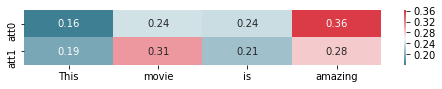

In [16]:
# Visualizing the attention layer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.squeeze(att.asnumpy(), 0).shape
plt.figure(figsize=(8,1))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(np.squeeze(att.asnumpy(), 0), cmap=cmap, annot=True,
            xticklabels=['This', 'movie', 'is', 'amazing'], yticklabels=['att0', 'att1'])
plt.show()

## Conclusions

Word embedding can effectively represent the semantic similarity between words, which allows for many breakthroughs in complex natural language processing tasks. Attention mechanisms can intuitively grasp the important semantic features in the sentence. The LSTM captures the word-order relationship between words in a sentence. Through a combination of these three, word embeddings, LSTMs, and attention mechanisms, we can effectively represent the semantics of a sentence and apply it to many practical tasks.

GluonNLP provides us with an efficient and convenient toolbox to help us experiment quickly. This greatly simplifies the tedious work of many natural language processing tasks.

## References

1. [A Structured Self-Attentive Sentence Embedding](https://arxiv.org/pdf/1703.03130.pdf)
2. [Glove: Global vectors for word representation. In Proceedings of the 2014 conference on empirical methods in natural language processing](https://nlp.stanford.edu/pubs/glove.pdf)
3. [Long short-term memory](https://www.bioinf.jku.at/publications/older/2604.pdf)
4. [Skymind.AI A Beginner's Guide to Attention Mechanisms and Memory Networks](https://skymind.ai/wiki/attention-mechanism-memory-network)